In [ ]:
!pip install yfinance gym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Set up environment

In [ ]:
import gym
import numpy as np
import pandas as pd
import yfinance as yf
import torch

class PortfolioOptimizationEnv(gym.Env):
    def __init__(self, tickers, window_size, start_date, end_date,
                 initial_balance, seed=None):
        super().__init__()

        # Initialize the environment's properties
        self.tickers = tickers
        self.window_size = window_size
        self.initial_balance = initial_balance

        # Download historical stock data
        self.data = self.get_data(tickers, start_date, end_date)

        # Define the action and observation spaces
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(len(tickers),))
        self.observation_space = gym.spaces.Box(low=0, high=np.inf,
                                        shape=(window_size, len(tickers)))

        # Set the random seed for reproducibility
        if seed is not None:
            np.random.seed(seed)
            self.action_space.seed(seed)

    def get_data(self, tickers, start_date, end_date):
        # Download historical stock data using yfinance
        data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
        return data.dropna()  # drop rows with nan values

    def reset(self):
        # Reset the environment to its initial state
        self.balance = self.initial_balance
        self.current_step = self.window_size

        # Return the initial observation (historical stock prices)
        obs = self.data.iloc[self.current_step - self.window_size:self.current_step].values
        return obs.reshape(self.observation_space.shape)

    def step(self, action):
        # Normalize the action values (portfolio weights) so they sum to one
        action = action / (np.sum(action) + 1e-8)  # where 1e-8 is a small constant

        # Calculate the previous balance and asset returns
        prev_balance = self.balance
        asset_prices = self.data.iloc[self.current_step].values
        asset_returns = asset_prices / self.data.iloc[self.current_step - 1].values - 1

        # Update the portfolio balance based on the weighted asset returns
        self.balance = self.balance * (1 + np.sum(asset_returns * action))

        # Calculate the reward as the logarithmic return of the portfolio
        reward = np.log(self.balance / prev_balance)

        # Update the current step and check if the episode is done
        self.current_step += 1
        done = self.current_step == len(self.data) - 1

        # Generate the next observation (historical stock prices)
        obs = self.data.iloc[self.current_step - self.window_size:self.current_step].values

        # Include the current balance in the info dictionary
        info = {'balance': self.balance}

        return obs.reshape(self.observation_space.shape), reward, done, info


In [ ]:
tickers = ['AAPL', 'GOOG', 'MSFT']
window_size = 30
start_date = '2022-01-01'
end_date = '2023-01-01'
initial_balance = 1000
seed = 8

# Initialize the environment
env = PortfolioOptimizationEnv(tickers, window_size, start_date, end_date,
                               initial_balance, seed)

# Get the initial state
state = env.reset()

# Sample and execute a random action
action = env.action_space.sample()
next_state, reward, done, _ = env.step(action)

# print(f"State: {state}")
print(f"Action: {action}")
# print(f"Next state: {next_state}")
print(f"Reward: {reward}")
print(f"Done: {done}")


[*********************100%***********************]  3 of 3 completed
Action: [0.32697228 0.98727685 0.31871083]
Reward: 0.013196830191594162
Done: False


In [ ]:
print(env.balance)

1013.2842926741703


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
initial_balance

1000

# Training DRL agent

In [ ]:
!pip install "stable-baselines3[extra]>=2.0.0a4"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv

# Initialize the environment
tickers = ['AAPL', 'GOOG', 'TSLA']
window_size = 20
start_date = '2010-01-01'
end_date = '2022-12-31'
initial_balance = 10000

env = PortfolioOptimizationEnv(tickers, window_size, start_date, end_date, initial_balance)
env = DummyVecEnv([lambda: env])  # The algorithms require a vectorized environment to run

# Initialize the agent
model = PPO('MlpPolicy', env, verbose=1)

# Train the agent
model.learn(total_timesteps=10000)

# Save the agent
model.save('ppo_portfolio_optimization')


[*********************100%***********************]  3 of 3 completed
Using cuda device


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


-----------------------------
| time/              |      |
|    fps             | 603  |
|    iterations      | 1    |
|    time_elapsed    | 3    |
|    total_timesteps | 2048 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 510          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0034552927 |
|    clip_fraction        | 0.0542       |
|    clip_range           | 0.2          |
|    entropy_loss         | -4.25        |
|    explained_variance   | 0.0904       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.00497     |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00445     |
|    std                  | 0.994        |
|    value_loss           | 0.0054       |
----------------

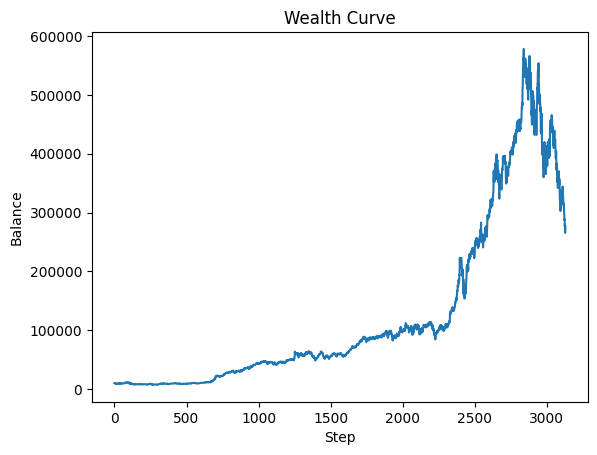

In [ ]:
import matplotlib.pyplot as plt

def plot_wealth_curve(model, env):
    obs = env.reset()
    done = [False]
    balances = []

    while not all(done):
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        balances.append(info[0]['balance'])

    plt.plot(balances)
    plt.xlabel('Step')
    plt.ylabel('Balance')
    plt.title('Wealth Curve')
    plt.show()

    return balances

# Load the trained agent
model = PPO.load('ppo_portfolio_optimization')

balances = plot_wealth_curve(model, env)


[*********************100%***********************]  3 of 3 completed


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


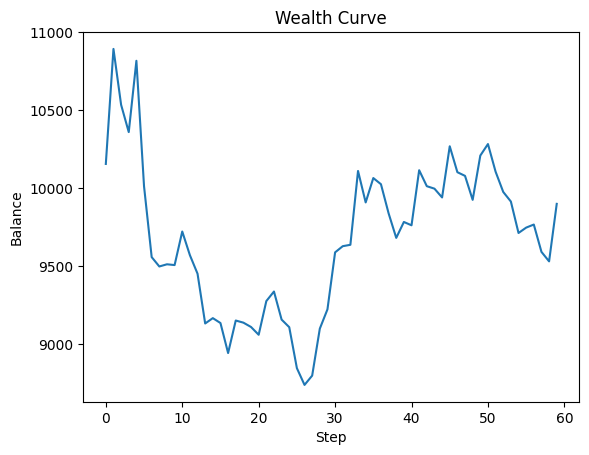

In [ ]:
# Define the test period
test_start_date = '2023-01-01'
test_end_date = '2023-05-01'

# Create a new environment with the test data
test_env = PortfolioOptimizationEnv(tickers, window_size, test_start_date, test_end_date, initial_balance)

# Wrap the environment in a DummyVecEnv for compatibility with Stable Baselines
test_env = DummyVecEnv([lambda: test_env])

# Plot the wealth curve on the test data
balances = plot_wealth_curve(model, test_env)


In [ ]:
def calculate_terminal_return(initial_balance, final_balance):
    return ((final_balance - initial_balance) / initial_balance) * 100

final_balance = balances[-1]
terminal_return = calculate_terminal_return(initial_balance, final_balance)
print(f'Terminal return: {terminal_return}%')


Terminal return: -0.9989908567661042%


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
